<a href="https://colab.research.google.com/github/heinohen/Textual-Data-Analysis/blob/main/TDA_exercise9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Binary relation extraction**
In this exercice, we will work on relation extraction part of the [Bacteria Biotope task at BioNLP Open Shared Tasks 2019.](https://aclanthology.org/D19-5719/).

The task is a binary relation extraction, with three entity types:

*  Microorganism (e.g. bacteria)
*  Habitat (e.g. milk, cheese, etc)
*  Geographical (e.g. Europe)

and one binary relaiton type: *Lives_in*
in the form of:
*   *Lives_in*(Microorganism , Habitat)
*   *Lives_in*(Microorganism , Geographical)

Which is Positive if the sentence states that the Microorganism lives in the mentioned Habitat/Geographical and Negative, otherwise.

Therefore, **candiate pairs** should be always created between (Microorganism , Habitat) and (Microorganism , Geographical), but other combinations are not logically meaningful.

Each candidate pair, based on what the sentences states, can be Positive (in that case, we extract such relationship), or a Negative (in that case we do not extract that relation).

Here is an example:
* **Salmonella** was noticed in **raw chicken**. --> Positive --> *Lives_in* (Salmonella, raw chicken)
* **Salmonella** was not noticed in **coocked chicken**. --> Negative

The original task also includes one other relation type, but for simplicity, you will work with a converted dataset that only contains Lives_in relation.

In this task you will use gpt-4o-mini with the api_key that was provided to you previously.

Let's first donwload the training and development datasets.

In [87]:
!wget -O BB4_converted_train.json https://raw.githubusercontent.com/TurkuNLP/textual-data-analysis-course/main/BB4_converted_train.json
!wget -O BB4_converted_devel.json https://raw.githubusercontent.com/TurkuNLP/textual-data-analysis-course/main/BB4_converted_devel.json
!pip install --quiet openai pydantic scikit-learn


--2025-02-14 07:15:33--  https://raw.githubusercontent.com/TurkuNLP/textual-data-analysis-course/main/BB4_converted_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 362894 (354K) [text/plain]
Saving to: ‘BB4_converted_train.json’

BB4_converted_train 100%[===================>] 354.39K  --.-KB/s    in 0.04s   

2025-02-14 07:15:34 (7.83 MB/s) - ‘BB4_converted_train.json’ saved [362894/362894]

--2025-02-14 07:15:34--  https://raw.githubusercontent.com/TurkuNLP/textual-data-analysis-course/main/BB4_converted_devel.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP reque

In [88]:
# moved all imports to here

from openai import OpenAI
from pydantic import BaseModel
from typing import Dict
from sklearn.metrics import precision_recall_fscore_support
import json
from google.colab import userdata
import matplotlib.pyplot as plt
import numpy as np



Now let's read the files and inspect their format.

In [89]:
def read_json(file_name):
  with open(file_name, "rt" , encoding = 'utf-8') as f:
    data = json.load(f)
  return data

train = read_json("BB4_converted_train.json")
devel = read_json("BB4_converted_devel.json")

print("training documents:" , len(train))
print("development documents:" , len(devel))


training documents: 125
development documents: 64


Now let's familiarize ourselves with file format.

In [90]:
print (train.keys())
train_doc_id = "BB-rel-F-22177851-012"
for item in train[train_doc_id].items():
  print (item)


dict_keys(['BB-rel-F-22177851-006', 'BB-rel-F-22177851-012', 'BB-rel-18845825', 'BB-rel-9526514', 'BB-rel-12970344', 'BB-rel-F-22177851-013', 'BB-rel-F-22177851-007', 'BB-rel-6143890', 'BB-rel-17237163', 'BB-rel-10738994', 'BB-rel-16990433', 'BB-rel-24678646', 'BB-rel-F-22177851-011', 'BB-rel-F-22177851-005', 'BB-rel-F-22177851-004', 'BB-rel-25634638', 'BB-rel-F-22177851-010', 'BB-rel-8607503', 'BB-rel-F-18524407-001', 'BB-rel-F-22177851-014', 'BB-rel-F-22177851-000', 'BB-rel-F-23290227-000', 'BB-rel-8347510', 'BB-rel-F-22177851-001', 'BB-rel-F-22177851-015', 'BB-rel-448557', 'BB-rel-F-18524407-000', 'BB-rel-14645268', 'BB-rel-11410343', 'BB-rel-21917915', 'BB-rel-F-22177851-003', 'BB-rel-F-22177851-017', 'BB-rel-9643457', 'BB-rel-F-22177851-002', 'BB-rel-16263187', 'BB-rel-F-25496341-009', 'BB-rel-6631408', 'BB-rel-24831788', 'BB-rel-2696427', 'BB-rel-F-25496341-008', 'BB-rel-19099664', 'BB-rel-F-23224222-009', 'BB-rel-F-23224222-008', 'BB-rel-16432479', 'BB-rel-25098305', 'BB-rel-243

As you can see, each document in the training or development set has a key, and it is a python dictionary, with "text" , "entities" , and "relations".

* Entities have ids, starting with "T", type, and begining and end offsets in the text. **Some entities have multiple spans.**

* Relations are also have ids, starting with "R" , and two arguments (entities). The first argument (e1), is always a Microorganism, and the second argument (e2) is either a "Habitat", or a "Geographical" location.

**because this is manually annotated dataset, only positive pairs are annotated. We can generate all candidate pairs, and those that are annotated, are Positive examples, and those which we cannot find in the relations part, are the negative examples.**

In above example, there is only one Habitat, one Microorganism, and one (Positive) relation between them.


**But a document can have more than two entities and relations. Here is an example**

In [91]:
train_doc_id = "BB-rel-F-22177851-006"
print ("TEXT=", train[train_doc_id]['text'])
print ("Entities:")
for entity_id in train[train_doc_id]['entities']:
  print (entity_id , ":" , train[train_doc_id]['entities'][entity_id])

print ("Positive relations:")
for positive_relation_id in train[train_doc_id]['relations']:
  print(positive_relation_id, ":" , train[train_doc_id]['relations'][positive_relation_id])
print("-"*80)

TEXT= The strain S3 + and its protease-negative variant S3-, assigned to Lactococcus lactis sp. lactis, was used for cheese-making. The 11 microorganisms that composed the model community included seven bacteria — Lactobacillus casei FH1, Arthrobacter arilaitensis Re117, Corynebacterium casei Mu120, C. flavescens Mu128, C. variabile Mu129, Staphylococcus xylosus Com1 and S. equorum Mu2 — and four yeasts — D. hansenii DH68, G. candidum GC129, Y. lipolytica CI35 and K. lactis
 KL65. This composition is representative of the diversity of smear soft
 cheese. The microorganisms were originally isolated from Munster except
 for Re117 (Reblochon), Com1 (unknown) and FH1 (St. Nectaire). The 
Gram-negative bacteria studied, P. celer 91 and H. alvei
 2 920, isolated from Livarot and Munster cheese, respectively, were 
chosen from a large cheese bacteria collection for their low level of 
sanitary risk (sensitivity to 24 antibiotics, no production of biogenic 
amines in synthetic media and no gro

Now, let's make a function that can tag entity spans, based on entity types:

In [92]:
def mark_entities_with_entity_tags(text, entities):
    """
    Annotate text with XML-like tags inserted directly into the text.

    For each entity we assume the structure:
      { "type": <entity type>, "offsets": [[start, end]], "text": <...> }

    Overlapping annotations will be handled by inserting tags at the boundaries.
    (If spans cross rather than nest, the output may have crossing tags; in many
    applications you would split such spans to get a well-formed nesting.)

    Returns:
      A new string with opening and closing tags inserted.
      For example: <Habitat>experimental smear soft cheese</Habitat>
    """
    events = []
    # For each entity (each value in the dictionary) add a start event and an end event.
    for ent in entities.values():
        tag = ent["type"]
        for start, end in ent["offsets"]:
            # Save event as (position, event_type, auxiliary, tag)
            # For a start event, we record the end position as auxiliary (so we can sort descending by end)
            # For an end event, we record the start position (so we can sort ascending by start).
            events.append((start, "start", end, tag))
            events.append((end, "end", start, tag))

    # Define a sort key so that:
    #   - Primary: sort by position.
    #   - At the same position, "end" events come before "start" events.
    #   - For start events at the same position, those with later (higher) end come first (so that outer tags open first).
    #   - For end events at the same position, those with earlier start come first.
    def event_sort_key(e):
        pos, etype, aux, tag = e
        if etype == "end":
            return (pos, 0, aux)  # lower auxiliary value first
        else:  # "start"
            return (pos, 1, -aux)  # higher aux (later end) first

    events.sort(key=event_sort_key)

    # Now, we iterate over the sorted events and insert tag strings at the appropriate positions.
    # We'll build a list of (position, string_to_insert) items.
    inserts = []
    for pos, etype, aux, tag in events:
        if etype == "end":
            inserts.append((pos, f"</{tag}>"))
        else:
            inserts.append((pos, f"<{tag}>"))

    # Because multiple inserts may occur at the same position, group them.
    # We already sorted events so that the insertions are in the correct order.
    # Now, build the annotated text by iterating through the text and inserting tags at the right offsets.
    result = []
    last_index = 0
    for pos, insert_text in inserts:
        # Append the text between the last index and current position.
        if pos > last_index:
            result.append(text[last_index:pos])
        # Append the tag.
        result.append(insert_text)
        last_index = pos
    # Append any remaining text.
    result.append(text[last_index:])
    return "".join(result)

train_doc_id = "BB-rel-607884"
for item in train[train_doc_id].items():
  print (item)

print ("-"*80)
text = train[train_doc_id]['text']
entities = train[train_doc_id]['entities']
print ("ORIGINAL TEXT :  ", text)
print ("ENCODED TEXT :   ", mark_entities_with_entity_tags(text, entities))
print ("-"*80)

('text', '[The infections from "Serratia" in the Hospital S. Camillo De Lellis of Roma (Italy) (author\'s transl)].\n\n')
('entities', {'T2': {'type': 'Microorganism', 'offsets': [[22, 30]], 'text': 'Serratia'}, 'T3': {'type': 'Habitat', 'offsets': [[39, 68]], 'text': 'Hospital S. Camillo De Lellis'}, 'T4': {'type': 'Geographical', 'offsets': [[72, 76]], 'text': 'Roma'}, 'T5': {'type': 'Geographical', 'offsets': [[78, 83]], 'text': 'Italy'}})
('relations', {'R1': {'type': 'Lives_In', 'e1': 'T2', 'e2': 'T5', 'e1_type': 'Microorganism', 'e2_type': 'Location'}, 'R2': {'type': 'Lives_In', 'e1': 'T2', 'e2': 'T3', 'e1_type': 'Microorganism', 'e2_type': 'Location'}, 'R3': {'type': 'Lives_In', 'e1': 'T2', 'e2': 'T4', 'e1_type': 'Microorganism', 'e2_type': 'Location'}})
--------------------------------------------------------------------------------
ORIGINAL TEXT :   [The infections from "Serratia" in the Hospital S. Camillo De Lellis of Roma (Italy) (author's transl)].


ENCODED TEXT :    [The

**There are two possibilities now:**
1. Marking full texts with all entities, and asking GPT to extract all possible relations Lives_in(Microorganism, Habitat/Geographical), and hope for the best.
But then we will need to process the output for an accurate evaluation, **which can get tricky**.

2. Generative all possible positive and negative pairs, assign them unique relation id, then feeding each example separately to GPT (or pack them together), and asking for predicting the label to be positive or negative.

Here is the second approach:

In [93]:
from itertools import product

def generate_and_mark_all_candidate_pairs(_dataset):
  unique_relation_id_index = 0
  results = []
  for document_id in _dataset:
    text = _dataset[document_id]['text']
    entities = _dataset[document_id]['entities']
    ent_microorganisms = [e_id for e_id in entities if entities[e_id]['type'] == "Microorganism"]
    ent_locations = [e_id for e_id in entities if entities[e_id]['type'] in ["Geographical", "Habitat"]]
    # generate all possible pairs
    candidate_pairs = list(product(ent_microorganisms, ent_locations))

    # look at relations to get information about all positive pairs
    relations = _dataset[document_id]['relations']
    positive_pairs = (relations.items())
    positive_pairs = set([(b['e1'], b['e2']) for (a, b) in relations.items()])

    for (a, b) in candidate_pairs:
      this_example_entities = dict()
      this_example_entities[a] = entities[a]
      this_example_entities[b] = entities[b]
      if (a, b) in positive_pairs:
        this_example_label = "Positive"
      else:
        this_example_label = "Negative"

      ml_example = {"UID" : "UID_" + str(unique_relation_id_index),
                    "doc_id": document_id,
                    "e1" : a ,
                    "e2" : b ,
                    "text": text,
                    "marked_text": mark_entities_with_entity_tags(text, this_example_entities),
                    "label": this_example_label}
      results.append(ml_example)
      unique_relation_id_index += 1
  return results

train_examples = generate_and_mark_all_candidate_pairs(train)
devel_examples = generate_and_mark_all_candidate_pairs(devel)

for example in train_examples:
  if example['doc_id'] == "BB-rel-607884":
    print(example)
print("-"*80)


{'UID': 'UID_3158', 'doc_id': 'BB-rel-607884', 'e1': 'T2', 'e2': 'T3', 'text': '[The infections from "Serratia" in the Hospital S. Camillo De Lellis of Roma (Italy) (author\'s transl)].\n\n', 'marked_text': '[The infections from "<Microorganism>Serratia</Microorganism>" in the <Habitat>Hospital S. Camillo De Lellis</Habitat> of Roma (Italy) (author\'s transl)].\n\n', 'label': 'Positive'}
{'UID': 'UID_3159', 'doc_id': 'BB-rel-607884', 'e1': 'T2', 'e2': 'T4', 'text': '[The infections from "Serratia" in the Hospital S. Camillo De Lellis of Roma (Italy) (author\'s transl)].\n\n', 'marked_text': '[The infections from "<Microorganism>Serratia</Microorganism>" in the Hospital S. Camillo De Lellis of <Geographical>Roma</Geographical> (Italy) (author\'s transl)].\n\n', 'label': 'Positive'}
{'UID': 'UID_3160', 'doc_id': 'BB-rel-607884', 'e1': 'T2', 'e2': 'T5', 'text': '[The infections from "Serratia" in the Hospital S. Camillo De Lellis of Roma (Italy) (author\'s transl)].\n\n', 'marked_text': '

This is another document with id = BB-rel-F-22177851-000



In [94]:
for item in train["BB-rel-F-22177851-000"].items():
  print (item)
print ("-"*40)
for example in train_examples:
  if example['doc_id'] == "BB-rel-F-22177851-000":
    print(example)


('text', 'Ecological and aromatic impact of two Gram-negative bacteria (Psychrobacter celer and Hafnia alvei) inoculated as part of the whole microbial community of an experimental smear soft cheese\n')
('entities', {'T2': {'type': 'Microorganism', 'offsets': [[62, 81]], 'text': 'Psychrobacter celer'}, 'T3': {'type': 'Microorganism', 'offsets': [[86, 98]], 'text': 'Hafnia alvei'}, 'T4': {'type': 'Habitat', 'offsets': [[132, 187]], 'text': 'microbial community of an experimental smear soft chees'}, 'T5': {'type': 'Habitat', 'offsets': [[158, 188]], 'text': 'experimental smear soft cheese'}})
('relations', {'R2': {'type': 'Lives_In', 'e1': 'T2', 'e2': 'T5', 'e1_type': 'Microorganism', 'e2_type': 'Location'}, 'R4': {'type': 'Lives_In', 'e1': 'T3', 'e2': 'T5', 'e1_type': 'Microorganism', 'e2_type': 'Location'}})
----------------------------------------
{'UID': 'UID_856', 'doc_id': 'BB-rel-F-22177851-000', 'e1': 'T2', 'e2': 'T4', 'text': 'Ecological and aromatic impact of two Gram-negative 

Now let's look how many positive and negative examples are in the devel set:

In [95]:
pos , neg = 0 , 0
for example in devel_examples:
  if example['label'] == 'Positive':
    pos+=1
  else:
    neg+=1

print ("there are" , pos , "Positive examples in the devel set.")
print ("there are" , neg , "Negative examples in the devel set.")


there are 453 Positive examples in the devel set.
there are 6786 Negative examples in the devel set.


Now, let's work with a subset of devel set:  

In [96]:
threshold = 400 #text length
filtered_devel = dict()
for doc_id in devel:
  if len(devel[doc_id]['text']) <= threshold:
    filtered_devel[doc_id] = devel[doc_id]

print ("documents in filtered devel:", len(filtered_devel))
filtered_devel_examples = generate_and_mark_all_candidate_pairs(filtered_devel)
pos , neg = 0 , 0
for example in filtered_devel_examples:
  if example['label'] == "Positive":
    pos+= 1
  else:
    neg+= 1

print ("positives in filtered devel: " , pos)
print ("negatives in filtered devel: " , neg)
print ("total: " , pos + neg)


documents in filtered devel: 13
positives in filtered devel:  46
negatives in filtered devel:  45
total:  91


In [97]:
client = OpenAI(api_key = userdata.get('openai'))

from pydantic import BaseModel
from typing import List

class MLExample(BaseModel):
    UID: str
    label: str  # Assuming 'positive' is a string

class Preds(BaseModel):
    data: List[MLExample]  # A list of Item dictionaries

def get_predictions_from_GPT(user_prompt):
  system_prompt = """
  Your task is to do binary relation extraction, for a few given input sentences.
  Each given sentence has a unique identifier  (UID).
  For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not.
  - If positive: you should return {"UID": UID of the example, "label": "Positive"}, a dictionary with UID: str, and Label ="Positive"
  - If negative: you should return {"UID": UID of the example, "label": "Negative"}, a dictionary with UID: str, and Label ="Negative"

  you can pack all the results, and give the output as a list of dictionaries.
  """
  completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": user_prompt},
    ],
    response_format=Preds,
  )

  message = completion.choices[0].message
  preds = completion.choices[0].message.parsed
  return (message, preds)

user_prompt = """
In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

UID: 0  Text = <Microorganism>Salmonella</Microorganism> was noticed in <Habitat>raw chicken</Habitat>.
UID: 1  Text = <Microorganism>Salmonella</Microorganism> was not noticed in <Habitat>coocked chicken</Habitat>.
"""
res = get_predictions_from_GPT(user_prompt)
print (res[1].data)


[MLExample(UID='0', label='Positive'), MLExample(UID='1', label='Negative')]


You have 3 tasks:

**Task1:**

Write a code that predicts the labels for all examples in `filtered_devel_examples` (there a 91 examples in this set) by asking the GPT model. You **must** use a `for` loop that packs **5 examples in at-a-time** (in each iteration of the for loop), and predicts the labels for them at once. This is to keep GPT costs low (a real situation if you're going to work for a company). Then use `sklearn.metrics.precision_recall_fscore_support` to calculate precision, recall, and f1-score for the `filtered_devel_examples`.
Do **NOT **give any example inputs to the GPT (no few-shot learning in this step).

**Task2:**

now, include the two positive and negative sentence about Salmonella and chicken that I had mentioned, as examples in your prompts.  

- "UID: UID_1000  Text = <Microorganism>Salmonella</Microorganism> was noticed in <Habitat>raw chicken</Habitat>. --> {'UID':'UID_1000', label = 'Positive'}

- "UID: UID_1001  Text = <Microorganism>Salmonella</Microorganism> was not noticed in <Habitat>coocked chicken</Habitat>. --> {'UID':'UID_1001', label = 'Negative'}"

and repeat the experiment, and report precision, recall, and f1-score.
How the results have changed?

**Task3:**

3.1 Now **randomly** select 4 examples from the **training set** (you can take 2 positives, 2 negatives, or really sample randomly) and include them in your prompt, repeat the experiment, report precision, recall, and f1-score.
How the results have changed?

3.2 Repeat above experiment: Again, **randomly** sample 4 training examples and use them **instead** of the 4 previous examples. Have the results changed? **Why?**  

In order not to get a time-out error from GPT call, you can increas the timeout, **but also make sure you sample from smaller texts.**

### HELPERS

In [98]:

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#precision
#float (if average is not None) or array of float, shape = [n_unique_labels]
#Precision score.

#recall
#float (if average is not None) or array of float, shape = [n_unique_labels]
#Recall score.

#fbeta_score
#float (if average is not None) or array of float, shape = [n_unique_labels]

#F-beta score.
#support
#None (if average is not None) or array of int, shape = [n_unique_labels]
#        The number of occurrences of each label in y_true.
def calculate_scores(y_true, y_p) -> tuple:
  prec, rec, fs, supp = precision_recall_fscore_support(y_true, y_p, pos_label = 'Positive',average='binary')
  return (prec,rec,fs,supp)

In [99]:
# add the predictions to a dict

def generate_dict(list_of_replies) -> dict:
  replies_dict = {}
  for r in list_of_replies:
    pack = [e for e in r[1].data]
    for p in pack:
      replies_dict[p.UID] = p.label

  return replies_dict

In [100]:

def plot_it(x,prec,rec,fs):
  plt.plot(x, prec, label='Precision', marker='o')
  plt.plot(x, rec, label='Recall', marker='x')
  plt.plot(x, fs, label='F-score', marker='^')

  plt.ylim(0,1.05)
  plt.yticks(np.arange(0, 1.05, step=0.05))
  plt.tick_params(axis='x')
  plt.xticks(rotation=45, ha='right')
  plt.xlabel('Type of prompt')
  plt.ylabel('Performance')
  plt.title('Zero-shot vs. Few-shot')

  plt.legend()
  plt.show()


## TASK 1

In [101]:
restriction = 5 # You must use a for loop that packs 5 examples in at-a-time (in each iteration of the for loop)
T_1_REPLIES_FROM_GPT = [] # stores all replies


for i in range(0, len(filtered_devel_examples), restriction):
  user_prompt = """
                In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
                For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."
                """
  for j in range(restriction): # try to add 5 examples
      if i + j < len(filtered_devel_examples): # if were not going over the index bounds with i + j values
          curr = filtered_devel_examples[i+j]
          user_prompt += f"UID: {curr['UID']}  Text = {curr['text']}\n" # only then  concat to the user_prompt
  T_1_REPLIES_FROM_GPT.append(get_predictions_from_GPT(user_prompt)) # call GPT with the 5 or less examples at the time


In [102]:
T_1_DICT_OF_REPLIES = generate_dict(T_1_REPLIES_FROM_GPT)

In [103]:
y_true = [y['label'] for y in filtered_devel_examples]

T_1_DICT_OF_REPLIES = generate_dict(T_1_REPLIES_FROM_GPT)
print(f'length of the dict should match {len(filtered_devel_examples)} ?? {len(T_1_DICT_OF_REPLIES)}')
assert len(T_1_DICT_OF_REPLIES) == len(filtered_devel_examples), 'Predicted text must be of the same size than the input data'
t1_y_pred = [y_pred for y_pred in T_1_DICT_OF_REPLIES.values()]
print(len(t1_y_pred))
assert len(t1_y_pred) == len(filtered_devel_examples), 'Predictions must be of the same size than the input data'

length of the dict should match 91 ?? 91
91


In [104]:
t1_precision, t1_recall, t1_fscore, _ = calculate_scores(y_true, t1_y_pred)


print(f'Precision is {t1_precision:.3f}')
print(f'Recall is {t1_recall:.3f}')
print(f'F-Score is {t1_fscore:.3f}')

Precision is 0.416
Recall is 0.696
F-Score is 0.520


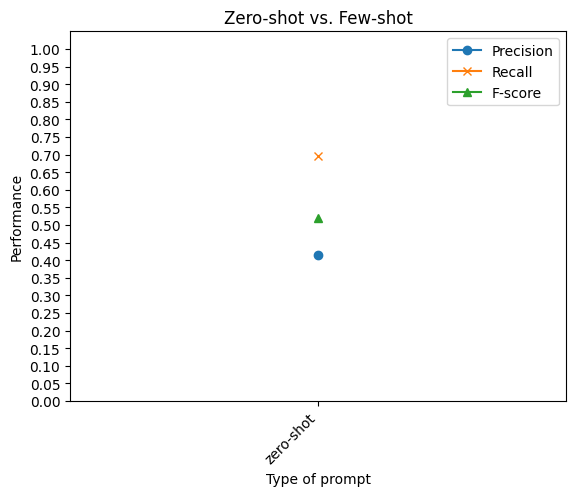

In [105]:
x = ["zero-shot"]
prec = [t1_precision]
rec = [t1_recall]
fs = [t1_fscore]

plot_it(x,prec,rec,fs)

so thats the baseline

## TASK 2

In [106]:
#now, include the two positive and negative sentence about Salmonella and chicken that I had mentioned, as examples in your prompts.
#"UID: UID_1000 Text = Salmonella was noticed in raw chicken. --> {'UID':'UID_1000', label = 'Positive'}
#"UID: UID_1001 Text = Salmonella was not noticed in coocked chicken. --> {'UID':'UID_1001', label = 'Negative'}"
#and repeat the experiment, and report precision, recall, and f1-score. How the results have changed?


restriction = 5 # You must use a for loop that packs 5 examples in at-a-time (in each iteration of the for loop)
T_2_REPLIES_FROM_GPT = [] # stores all replies


for i in range(0, len(filtered_devel_examples), restriction):
  user_prompt = """
                In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
                For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not.

                Examples:
                        "UID: UID_1000 Text = Salmonella was noticed in raw chicken. --> {'UID':'UID_1000', label = 'Positive'}
                        "UID: UID_1001 Text = Salmonella was not noticed in coocked chicken. --> {'UID':'UID_1001', label = 'Negative'}"
                """
  for j in range(restriction): # try to add 5 examples
      if i + j < len(filtered_devel_examples): # if were not going over the index bounds with i + j values
          curr = filtered_devel_examples[i+j]
          user_prompt += f"UID: {curr['UID']}  Text = {curr['text']}\n" # only then concat concat to the user_prompt
  T_2_REPLIES_FROM_GPT.append(get_predictions_from_GPT(user_prompt)) # call GPT with the 5 or less examples at the time


In [107]:
T_2_DICT_OF_REPLIES = generate_dict(T_2_REPLIES_FROM_GPT)
print(f'length of the dict should match {len(filtered_devel_examples)} ?? {len(T_2_DICT_OF_REPLIES)}')
assert len(T_2_DICT_OF_REPLIES) == len(filtered_devel_examples), 'Predicted text must be of the same size than the input data'
t2_y_pred = [y_pred for y_pred in T_2_DICT_OF_REPLIES.values()]
print(len(t2_y_pred))
assert len(t2_y_pred) == len(filtered_devel_examples), 'Predictions must be of the same size than the input data'

length of the dict should match 91 ?? 91
91


In [108]:
t2_precision, t2_recall, t2_fscore, _ = calculate_scores(y_true, t2_y_pred)


print(f'Precision is {t2_precision:.3f}')
print(f'Recall is {t2_recall:.3f}')
print(f'F-Score is {t2_fscore:.3f}')

Precision is 0.493
Recall is 0.804
F-Score is 0.612


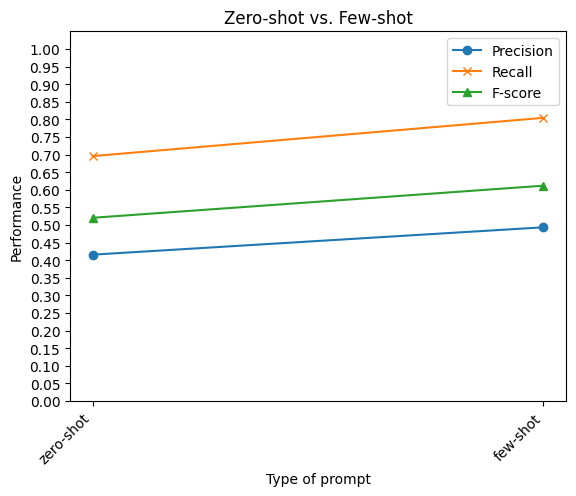

In [109]:

x = ["zero-shot", "few-shot"]
prec = [t1_precision, t2_precision]
rec = [t1_recall, t2_recall]
fs = [t1_fscore, t2_fscore]

plot_it(x,prec,rec,fs)

How the results have changed?

* All performance parameters went up a bit, i think mainly due to the fact that two examples were given

## TASK 3

### 3.1

 Now randomly select 4 examples from the training set (you can take 2 positives, 2 negatives, or really sample randomly) and include them in your prompt, repeat the experiment, report precision, recall, and f1-score. How the results have changed?


In [142]:
# the training examples live in "train_examples"
t3_1_examples = [] # list for examples
indices_used = []

positives = 0 # counters
negatives = 0

while positives < 2 or negatives < 2: # loop while we have 2 and 2
  rand = np.random.randint(0, len(train_examples)) # generate random integer

  if rand not in indices_used:
    if train_examples[rand]['label'] == 'Positive' and positives < 2: # check if its label is positive and we don't have 2 positives
      positives += 1
      t3_1_examples.append(train_examples[rand])
    elif train_examples[rand]['label'] == 'Negative' and negatives < 2: # or check if its label is negative and we don't have 2 negatives
      negatives += 1
      t3_1_examples.append(train_examples[rand])
    indices_used.append(rand) # collect the used index

In [143]:
for e in t3_1_examples:
  print(e)

{'UID': 'UID_4076', 'doc_id': 'BB-rel-F-23224222-003', 'e1': 'T27', 'e2': 'T21', 'text': 'The cheeses \nfrom dairies A and C were primarily dominated by the LAB starter \ncultures Leuconostoc mesenteroides and Lactococcus lactis subsp. lactis (Table 3). Furthermore, the cheeses from dairies A and C were dominated by the non-starter lactic acid bacteria (NSLAB) Lactobacillus paracasei, and for the cheese from dairy A, a minor group consisting of the NSLAB Lb. parabuchneri\n was found. The interior bacterial isolates from the cheeses from \ndairies B and D were primarily dominated by NSLAB. The cheese from dairy\n B was dominated by a range of NSLAB including Lb. brevis, Lb. oligofermentans and Lb. farminis, whereas the cheese from dairy D was exclusively dominated by the NSLAB Lb. paracasei. Additionally, minor groups of the LAB starter cultures Lc. lactis subsp. lactis and Lc. lactis subsp. cremoris were found on the cheeses from dairies B and D, respectively.\n', 'marked_text': 'The c

In [144]:
task_3_1_prompt = """
    In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
    For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

    I give you four examples starting below, use these four for only take example from. The examples end at the "END OF EXAMPLES" text\n\n
    """
i = 1
for j in t3_1_examples: # add 4 examples
    task_3_1_prompt += f"EXAMPLE {i}\n"
    task_3_1_prompt += f"UID: {j['UID']} Text = {j['text']} --> {{'UID':{j['UID']}, label = {j['label']}}}\n\n"
    i += 1

task_3_1_prompt += "END OF EXAMPLES\n\n"

In [145]:
# check the user prompt
print(task_3_1_prompt)


    In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
    For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

    I give you four examples starting below, use these four for only take example from. The examples end at the "END OF EXAMPLES" text


    EXAMPLE 1
UID: UID_4076 Text = The cheeses 
from dairies A and C were primarily dominated by the LAB starter 
cultures Leuconostoc mesenteroides and Lactococcus lactis subsp. lactis (Table 3). Furthermore, the cheeses from dairies A and C were dominated by the non-starter lactic acid bacteria (NSLAB) Lactobacillus paracasei, and for the cheese from dairy A, a minor group consisting of the NSLAB Lb. parabuchneri
 was found. The interior bacterial isolates from the cheeses from 
dairies B and D were primarily dominated by NSLAB. The cheese from dairy
 B was dominate

In [146]:
restriction = 5 # You must use a for loop that packs 5 examples in at-a-time (in each iteration of the for loop)
T_3_1_REPLIES_FROM_GPT = [] # stores all replies

for i in range(0, len(filtered_devel_examples), restriction):
  user_prompt = task_3_1_prompt
  for j in range(restriction): # try to add 5 examples
      if i + j < len(filtered_devel_examples): # if were not going over the index bounds with i + j values
          curr = filtered_devel_examples[i+j]
          user_prompt += f"UID: {curr['UID']}  Text = {curr['text']}\n" # only then  concat to the user_prompt
  if i == 0:
    print(user_prompt)
  T_3_1_REPLIES_FROM_GPT.append(get_predictions_from_GPT(user_prompt)) # call GPT with the 5 or less examples at the time



    In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
    For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

    I give you four examples starting below, use these four for only take example from. The examples end at the "END OF EXAMPLES" text


    EXAMPLE 1
UID: UID_4076 Text = The cheeses 
from dairies A and C were primarily dominated by the LAB starter 
cultures Leuconostoc mesenteroides and Lactococcus lactis subsp. lactis (Table 3). Furthermore, the cheeses from dairies A and C were dominated by the non-starter lactic acid bacteria (NSLAB) Lactobacillus paracasei, and for the cheese from dairy A, a minor group consisting of the NSLAB Lb. parabuchneri
 was found. The interior bacterial isolates from the cheeses from 
dairies B and D were primarily dominated by NSLAB. The cheese from dairy
 B was dominate

In [147]:
# collect the dict
T_3_1_DICT_OF_REPLIES = generate_dict(T_3_1_REPLIES_FROM_GPT)
# should match the length, the assert will check that
print(f'length of the dict should match {len(filtered_devel_examples)} ?? {len(T_3_1_DICT_OF_REPLIES)}')
assert len(T_3_1_DICT_OF_REPLIES) == len(filtered_devel_examples), 'Predicted text must be of the same size than the input data'
# take the predictions to a list
t3_1_y_pred = [y_pred for y_pred in T_3_1_DICT_OF_REPLIES.values()]
# again the assert will check that
print(len(t3_1_y_pred))
assert len(t3_1_y_pred) == len(filtered_devel_examples), 'Predictions must be of the same size than the input data'

length of the dict should match 91 ?? 91
91


In [148]:
# calculate pr, re, fs and support that is got from custom helper function
t3_1_precision, t3_1_recall, t3_1_fscore, _ = calculate_scores(y_true, t3_1_y_pred)

print(f'Precision is {t3_1_precision:.3f}')
print(f'Recall is {t3_1_recall:.3f}')
print(f'F-Score is {t3_1_fscore:.3f}')

Precision is 0.524
Recall is 0.478
F-Score is 0.500


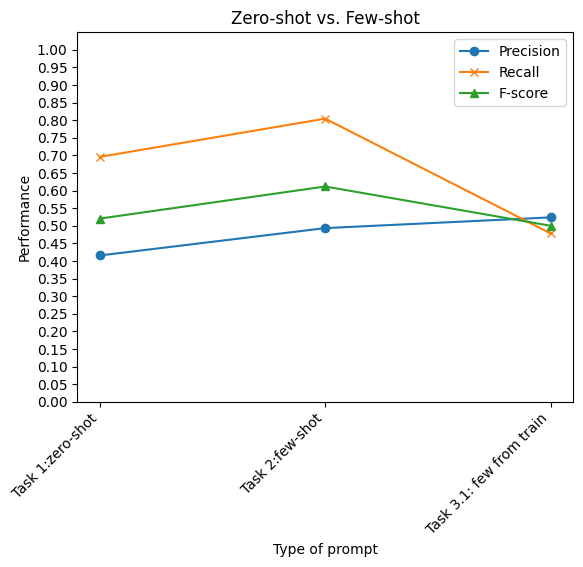

In [149]:
# just for plots
x = ["Task 1:zero-shot", "Task 2:few-shot", "Task 3.1: few from train"]
prec = [t1_precision, t2_precision, t3_1_precision]
rec = [t1_recall, t2_recall, t3_1_recall]
fs = [t1_fscore, t2_fscore, t3_1_fscore]

plot_it(x,prec,rec,fs)

How the results have changed?

* as can be seen from the plot, the recall is tanking from 0.8 to ~0.45. So the GPT model failed to predict _tp_ values as such. And as the f1 is based on pr and re values, the decline in re drags the f1 also down

### TASK 3.2

Repeat above experiment: Again, randomly sample 4 training examples and use them instead of the 4 previous examples. Have the results changed? Why?

In [150]:
# the training examples live in "train_examples"
t3_2_examples = [] # list for examples

positives = 0 # counters
negatives = 0

while positives < 2 or negatives < 2: # loop while we have 2 and 2
  rand = np.random.randint(0, len(train_examples)) # generate random integer

  if rand not in indices_used:
    if train_examples[rand]['label'] == 'Positive' and positives < 2: # check if its label is positive and we don't have 2 positives
      positives += 1
      t3_2_examples.append(train_examples[rand])
    elif train_examples[rand]['label'] == 'Negative' and negatives < 2: # or check if its label is negative and we don't have 2 negatives
      negatives += 1
      t3_2_examples.append(train_examples[rand])
    indices_used.append(rand) # ensure we dont use the same index, slim chance but still


In [151]:
for e in t3_2_examples:
  print(e)

{'UID': 'UID_3345', 'doc_id': 'BB-rel-6107735', 'e1': 'T19', 'e2': 'T18', 'text': 'Recurrence of Pelecypod-associated cholera in Sardinia.\nFrom Oct. 30 to Nov. 7, 1979, 10 people in the Sardinian province of Cagliari had onset of bacteriologically confirmed cholera. Two symptom-free excretors of Vibrio cholerae O:1 were detected in household contacts of the patients. There were no deaths. All but 1 of the 12 people with V. cholerae O:1 infection gave a history of recent consumption of marine bivalves known locally as arselle (pelecypods). Triplicate matched neighbourhood controls for each of the first 7 cases identified were also interviewed; none had recently eaten arselle. V. cholerae O:1 was also recovered from samples of water and bivalves obtained from a lagoon on the outskirts of the city of Cagliari. Arselle had also been implicated as the vehicle of transmission in 1973 in the last outbreak of cholera in Sardinia. It seems unlikely that cholera transmission had persisted local

In [152]:
task_3_2_prompt = """
    In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
    For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

    I give you four examples starting below, use these four for only take example from. The examples end at the "END OF EXAMPLES" text
    """
i = 1
for j in t3_2_examples: # add 4 examples
    task_3_2_prompt += f"EXAMPLE {i}\n"
    task_3_2_prompt += f"UID: {j['UID']} Text = {j['text']} --> {{'UID':{j['UID']}, label = {j['label']}}}\n\n"
    i += 1

task_3_2_prompt += "END OF EXAMPLES\n\n"

In [153]:
print(task_3_2_prompt)


    In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
    For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

    I give you four examples starting below, use these four for only take example from. The examples end at the "END OF EXAMPLES" text
    EXAMPLE 1
UID: UID_3345 Text = Recurrence of Pelecypod-associated cholera in Sardinia.
From Oct. 30 to Nov. 7, 1979, 10 people in the Sardinian province of Cagliari had onset of bacteriologically confirmed cholera. Two symptom-free excretors of Vibrio cholerae O:1 were detected in household contacts of the patients. There were no deaths. All but 1 of the 12 people with V. cholerae O:1 infection gave a history of recent consumption of marine bivalves known locally as arselle (pelecypods). Triplicate matched neighbourhood controls for each of the first 7 cases identif

In [154]:
restriction = 5 # You must use a for loop that packs 5 examples in at-a-time (in each iteration of the for loop)
T_3_2_REPLIES_FROM_GPT = [] # stores all replies

for i in range(0, len(filtered_devel_examples), restriction):
  user_prompt = task_3_2_prompt
  for j in range(restriction): # try to add 5 examples
      if i + j < len(filtered_devel_examples): # if were not going over the index bounds with i + j values
          curr = filtered_devel_examples[i+j]
          user_prompt += f"UID: {curr['UID']}  Text = {curr['text']}\n" # only then  concat to the user_prompt
  if i == 40:
    print(user_prompt)
  T_3_2_REPLIES_FROM_GPT.append(get_predictions_from_GPT(user_prompt)) # call GPT with the 5 or less examples at the time



    In the following sentences, check if the mentioned microrganism (e.g. bacteria), lives in the mentioned habitat/geographical entity or not.
    For each input sentence, you need to check if the mentioned <Microorganism>, lives in the mentioned <Habitat> (or <Geographical>, or not."

    I give you four examples starting below, use these four for only take example from. The examples end at the "END OF EXAMPLES" text
    EXAMPLE 1
UID: UID_3345 Text = Recurrence of Pelecypod-associated cholera in Sardinia.
From Oct. 30 to Nov. 7, 1979, 10 people in the Sardinian province of Cagliari had onset of bacteriologically confirmed cholera. Two symptom-free excretors of Vibrio cholerae O:1 were detected in household contacts of the patients. There were no deaths. All but 1 of the 12 people with V. cholerae O:1 infection gave a history of recent consumption of marine bivalves known locally as arselle (pelecypods). Triplicate matched neighbourhood controls for each of the first 7 cases identif

In [155]:
T_3_2_DICT_OF_REPLIES = generate_dict(T_3_2_REPLIES_FROM_GPT)
print(f'length of the dict should match {len(filtered_devel_examples)} ?? {len(T_3_2_DICT_OF_REPLIES)}')
assert len(T_3_2_DICT_OF_REPLIES) == len(filtered_devel_examples), 'Predicted text must be of the same size than the input data'
t3_2_y_pred = [y_pred for y_pred in T_3_2_DICT_OF_REPLIES.values()]
print(len(t3_2_y_pred))
assert len(t3_2_y_pred) == len(filtered_devel_examples), 'Predictions must be of the same size than the input data'

length of the dict should match 91 ?? 91
91


In [156]:
t3_2_precision, t3_2_recall, t3_2_fscore, _ = calculate_scores(y_true, t3_2_y_pred)


print(f'Precision is {t3_2_precision:.3f}')
print(f'Recall is {t3_2_recall:.3f}')
print(f'F-Score is {t3_2_fscore:.3f}')

Precision is 0.430
Recall is 0.739
F-Score is 0.544


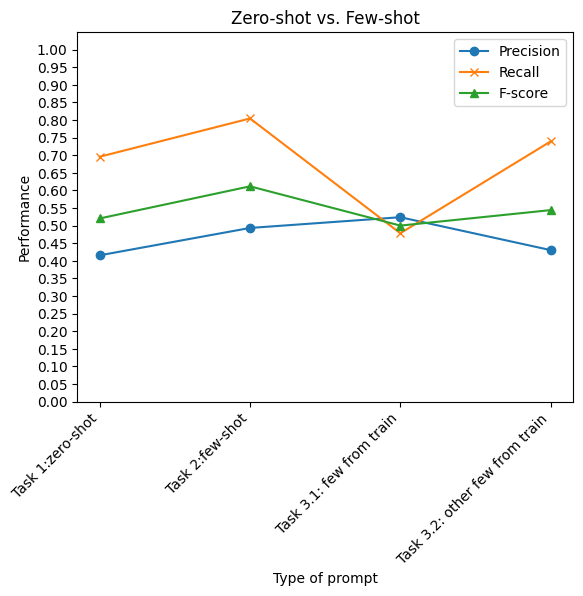

In [157]:
x = ["Task 1:zero-shot", "Task 2:few-shot", "Task 3.1: few from train", "Task 3.2: other few from train"]
prec = [t1_precision, t2_precision, t3_1_precision, t3_2_precision]
rec = [t1_recall, t2_recall, t3_1_recall, t3_2_recall]
fs = [t1_fscore, t2_fscore, t3_1_fscore, t3_2_fscore]

plot_it(x,prec,rec,fs)

Have the results changed? Why?

* Yes the results have changed. The recall is bouncing back to > 0.7 meaning that it is correctly predicting _tp_ values as ones. Precision is still decreasing from the Task 3.1. The model is tagging much of the actual negatives as positives. It could be due to the fact that there are duplicates in the devel set and it is just randomly guessing based on the precision performance